# Radio Map Completion with Scene-Aware RME-GAN

## Task Overview
- Input: 256×256 Radio Map with 20% pixels masked
- Output: Complete Radio Map prediction
- Dataset: 701 fixed maps × 80 base station positions
  - Training: 60 BS positions per map
  - Validation: 10 BS positions per map (from training set)
  - Test: 10 specific BS positions [7,12,25,30,38,45,52,60,65,74]
- Key Insight: Maps are shared between train and test, only BS positions differ

## 1. Environment Setup

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 31.36 GB


## 2. Data Configuration

In [2]:
TRAIN_PATH = os.path.join('Data', 'train')
TEST_PATH = os.path.join('Data', 'test(student)')
MASK_PATH = os.path.join(TEST_PATH, 'mask.csv')

OUTPUT_PATH = 'output_scene_aware'
MODEL_PATH = 'models_scene_aware'
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

# Test base stations (fixed)
TEST_BS = [7, 12, 25, 30, 38, 45, 52, 60, 65, 74]

# Validation base stations (selected from training BS)
VAL_BS = [3, 9, 15, 22, 33, 42, 51, 63, 69, 77]

# Training base stations (remaining 60)
ALL_TRAIN_BS = set(range(80)) - set(TEST_BS)
TRAIN_BS = list(ALL_TRAIN_BS - set(VAL_BS))

print(f"Training BS positions: {len(TRAIN_BS)}")
print(f"Validation BS positions: {len(VAL_BS)}")
print(f"Test BS positions: {len(TEST_BS)}")
print(f"Total maps: 701")

Training BS positions: 60
Validation BS positions: 10
Test BS positions: 10
Total maps: 701


## 3. Data Loading and Scene Organization

In [3]:
def load_masks(mask_path):
    masks = []
    with open(mask_path, 'r') as f:
        for line in f:
            coords = line.strip().split(',')
            if len(coords) == 4:
                masks.append([int(x) for x in coords])
    return masks

def apply_masks_to_image(img, masks, fill_value=0.5):
    img_masked = img.copy()
    mask_binary = np.ones_like(img)
    
    for mask in masks:
        x1, y1, x2, y2 = mask
        img_masked[y1:y2+1, x1:x2+1] = fill_value
        mask_binary[y1:y2+1, x1:x2+1] = 0
    
    return img_masked, mask_binary

class SceneAwareRadioMapDataset(Dataset):
    def __init__(self, data_path, masks, bs_positions, mode='train', augment=False):
        """
        Scene-aware dataset that organizes data by map_id and bs_id
        """
        self.data_path = data_path
        self.masks = masks
        self.mode = mode
        self.augment = augment
        self.bs_positions = bs_positions
        
        # Organize data by scene
        self.data_dict = {}  # {map_id: {bs_id: filename}}
        self.samples = []  # List of (map_id, bs_id) tuples
        
        if mode == 'test':
            # Test mode: use test path
            all_files = sorted([f for f in os.listdir(data_path) if f.endswith('.png')])
        else:
            # Train/val mode: use train path
            all_files = sorted([f for f in os.listdir(data_path) if f.endswith('.png')])
        
        for filename in all_files:
            parts = filename[:-4].split('_')
            map_id = int(parts[0])
            bs_id = int(parts[1])
            
            # Filter by BS positions
            if bs_id in bs_positions:
                if map_id not in self.data_dict:
                    self.data_dict[map_id] = {}
                self.data_dict[map_id][bs_id] = filename
                self.samples.append((map_id, bs_id))
        
        print(f"{mode} dataset: {len(self.samples)} samples, "
              f"{len(self.data_dict)} maps, {len(bs_positions)} BS positions")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        map_id, bs_id = self.samples[idx]
        filename = self.data_dict[map_id][bs_id]
        
        # Load image
        img_path = os.path.join(self.data_path, filename)
        img = Image.open(img_path).convert('L')
        img = np.array(img, dtype=np.float32) / 255.0
        
        # Apply masks
        img_masked, mask_binary = apply_masks_to_image(img, self.masks, fill_value=0.5)
        
        # Data augmentation (only for training)
        if self.augment and self.mode == 'train' and random.random() > 0.5:
            # Random horizontal flip
            if random.random() > 0.5:
                img = np.fliplr(img)
                img_masked = np.fliplr(img_masked)
                mask_binary = np.fliplr(mask_binary)
            # Random vertical flip
            if random.random() > 0.5:
                img = np.flipud(img)
                img_masked = np.flipud(img_masked)
                mask_binary = np.flipud(mask_binary)
        
        # Convert to tensors
        img_tensor = torch.from_numpy(img.copy()).unsqueeze(0)
        img_masked_tensor = torch.from_numpy(img_masked.copy()).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_binary.copy()).unsqueeze(0)
        
        return {
            'input': img_masked_tensor,
            'target': img_tensor,
            'mask': mask_tensor,
            'map_id': map_id,
            'bs_id': bs_id,
            'filename': filename
        }

# Load masks
masks = load_masks(MASK_PATH)
print(f"Loaded {len(masks)} masks (all 10x10 regions)")

Loaded 144 masks (all 10x10 regions)


## 4. Scene-Aware RME-GAN Architecture

In [4]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1

        conv_block += [
            nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
            norm_layer(dim),
            nn.ReLU(True)
        ]
        
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
            
        conv_block += [
            nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
            norm_layer(dim)
        ]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


class SceneAwareGenerator(nn.Module):
    """Scene-aware generator with map and BS embeddings"""
    def __init__(self, input_nc=2, output_nc=1, ngf=64, n_maps=701, n_bs=80,
                 embed_dim=128, norm_layer=nn.BatchNorm2d, use_dropout=False, 
                 n_blocks=9, padding_type='reflect'):
        super(SceneAwareGenerator, self).__init__()
        
        # Scene and BS embeddings
        self.map_embedding = nn.Embedding(n_maps, embed_dim)
        self.bs_embedding = nn.Embedding(n_bs, embed_dim)
        
        # Embedding projection to spatial features
        self.embed_proj = nn.Sequential(
            nn.Linear(embed_dim * 2, ngf * 4),
            nn.ReLU(True),
            nn.Linear(ngf * 4, ngf * 2),
            nn.ReLU(True)
        )
        
        use_bias = norm_layer == nn.InstanceNorm2d
        
        # Initial convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
            norm_layer(ngf),
            nn.ReLU(True)
        ]
        
        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                norm_layer(ngf * mult * 2),
                nn.ReLU(True)
            ]
        
        # ResNet blocks with scene conditioning
        mult = 2 ** n_downsampling
        self.resnet_blocks = nn.ModuleList()
        for i in range(n_blocks):
            self.resnet_blocks.append(
                ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer,
                          use_dropout=use_dropout, use_bias=use_bias)
            )
        
        # Conditioning injection layers
        self.cond_layers = nn.ModuleList()
        for i in range(n_blocks):
            self.cond_layers.append(
                nn.Conv2d(ngf * mult + ngf * 2, ngf * mult, kernel_size=1, bias=use_bias)
            )
        
        # Upsampling
        upsample = []
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            upsample += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                 kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias),
                norm_layer(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]
        
        # Output layer
        upsample += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
            nn.Sigmoid()
        ]
        
        self.initial_model = nn.Sequential(*model)
        self.upsample = nn.Sequential(*upsample)
    
    def forward(self, x, map_id, bs_id):
        # Get embeddings
        map_emb = self.map_embedding(map_id)
        bs_emb = self.bs_embedding(bs_id)
        
        # Combine embeddings
        combined_emb = torch.cat([map_emb, bs_emb], dim=1)
        cond_features = self.embed_proj(combined_emb)
        
        # Initial encoding
        x = self.initial_model(x)
        
        # Apply ResNet blocks with conditioning
        b, c, h, w = x.shape
        cond_spatial = cond_features.unsqueeze(-1).unsqueeze(-1).expand(b, -1, h, w)
        
        for i, (resnet, cond_layer) in enumerate(zip(self.resnet_blocks, self.cond_layers)):
            # Concatenate conditioning
            x_cond = torch.cat([x, cond_spatial], dim=1)
            x = cond_layer(x_cond)
            x = resnet(x)
        
        # Upsampling
        x = self.upsample(x)
        
        return x


# Test model
def test_model():
    model = SceneAwareGenerator(input_nc=2, output_nc=1, ngf=64, n_blocks=9)
    model = model.to(device)
    
    test_input = torch.randn(4, 2, 256, 256).to(device)
    test_map_id = torch.tensor([0, 1, 2, 3]).to(device)
    test_bs_id = torch.tensor([0, 1, 2, 3]).to(device)
    
    with torch.no_grad():
        output = model(test_input, test_map_id, test_bs_id)
    
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {output.shape}")
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

test_model()

Input shape: torch.Size([4, 2, 256, 256])
Output shape: torch.Size([4, 1, 256, 256])
Total parameters: 12,457,409


## 5. Loss Functions

In [5]:
class PerceptualLoss(nn.Module):
    """Simple perceptual loss using VGG-like features"""
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # Simple feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        for param in self.features.parameters():
            param.requires_grad = False
    
    def forward(self, pred, target):
        pred_features = self.features(pred)
        target_features = self.features(target)
        return F.l1_loss(pred_features, target_features)


class SceneAwareLoss(nn.Module):
    """Combined loss for scene-aware training"""
    def __init__(self, mse_weight=1.0, perceptual_weight=0.1, tv_weight=1e-6):
        super(SceneAwareLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.perceptual_loss = PerceptualLoss().to(device)
        
        self.mse_weight = mse_weight
        self.perceptual_weight = perceptual_weight
        self.tv_weight = tv_weight
        
        self.losses = {}
    
    def tv_loss(self, x):
        """Total variation loss for smoothness"""
        h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :-1, :], 2).mean()
        w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :-1], 2).mean()
        return h_tv + w_tv
    
    def forward(self, pred, target, mask):
        # Focus on masked regions
        mask_region = (1 - mask)
        
        # MSE loss on masked regions
        mse = self.mse_loss(pred * mask_region, target * mask_region)
        
        # L1 loss for better edge preservation
        l1 = self.l1_loss(pred * mask_region, target * mask_region)
        
        # Perceptual loss
        perceptual = self.perceptual_loss(pred, target)
        
        # TV loss
        tv = self.tv_loss(pred)
        
        # Combined loss
        total_loss = self.mse_weight * (0.7 * mse + 0.3 * l1) + \
                    self.perceptual_weight * perceptual + \
                    self.tv_weight * tv
        
        # Store individual losses (for internal use only)
        self.losses = {
            'l1': l1.item(),
            'perceptual': perceptual.item(),
            'tv': tv.item()
        }
        
        return total_loss


def calculate_nmse(pred, target, mask=None):
    """
    Calculate NMSE according to PDF formula: L = (1/(N×256²)) × ∑∑[M(i,j) - M̄(i,j)]²
    Note: This follows the teacher's grading standard exactly as specified.
    """
    mse = torch.mean((pred - target) ** 2)
    return mse.item()

## 6. Training Configuration

In [6]:
class Config:
    # Data
    batch_size = 32
    num_workers = 24
    augment = True
    
    # Model
    ngf = 64
    n_blocks = 9
    embed_dim = 128
    use_dropout = False
    
    # Training
    epochs = 100
    learning_rate = 0.0002
    beta1 = 0.5
    beta2 = 0.999
    weight_decay = 1e-5
    
    # Loss weights
    mse_weight = 1.0
    perceptual_weight = 0.1
    tv_weight = 1e-6
    
    # Schedule
    warmup_epochs = 5
    
    # Logging
    visualize_interval = 5
    save_interval = 10

config = Config()

# Create datasets
train_dataset = SceneAwareRadioMapDataset(
    TRAIN_PATH, masks, TRAIN_BS, mode='train', augment=config.augment
)
val_dataset = SceneAwareRadioMapDataset(
    TRAIN_PATH, masks, VAL_BS, mode='val', augment=False
)
test_dataset = SceneAwareRadioMapDataset(
    TEST_PATH, masks, TEST_BS, mode='test', augment=False
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size,
    shuffle=True, num_workers=config.num_workers, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=config.batch_size,
    shuffle=False, num_workers=config.num_workers, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=1,
    shuffle=False, num_workers=config.num_workers
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test samples: {len(test_loader)}")

train dataset: 42060 samples, 701 maps, 60 BS positions
val dataset: 7010 samples, 701 maps, 10 BS positions
test dataset: 7010 samples, 701 maps, 10 BS positions
Training batches: 1315
Validation batches: 220
Test samples: 7010


## 7. Training Functions

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device, epoch, config):
    model.train()
    running_loss = 0.0
    running_nmse = 0.0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}/{config.epochs}')
    
    for batch_idx, batch in enumerate(progress_bar):
        # Prepare data
        input_img = batch['input'].to(device)
        target_img = batch['target'].to(device)
        mask = batch['mask'].to(device)
        map_id = batch['map_id'].to(device)
        bs_id = batch['bs_id'].to(device)
        
        # Model input: concatenate masked image and mask
        model_input = torch.cat([input_img, mask], dim=1)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(model_input, map_id, bs_id)
        
        # Fuse with original
        fused_output = input_img * mask + output * (1 - mask)
        
        # Calculate loss
        loss = criterion(fused_output, target_img, mask)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        nmse = calculate_nmse(fused_output, target_img)
        running_nmse += nmse
        
        # Update progress bar
        if batch_idx % 10 == 0:
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4g}',
                'NMSE': f'{nmse:.4g}',
                'Perceptual': f'{criterion.losses.get("perceptual", 0):.4g}'
            })
    
    avg_loss = running_loss / len(dataloader)
    avg_nmse = running_nmse / len(dataloader)
    
    return avg_loss, avg_nmse


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_nmse = 0.0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validation'):
            # Prepare data
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            mask = batch['mask'].to(device)
            map_id = batch['map_id'].to(device)
            bs_id = batch['bs_id'].to(device)
            
            # Model input
            model_input = torch.cat([input_img, mask], dim=1)
            
            # Forward pass
            output = model(model_input, map_id, bs_id)
            
            # Fuse with original
            fused_output = input_img * mask + output * (1 - mask)
            
            # Calculate loss
            loss = criterion(fused_output, target_img, mask)
            nmse = calculate_nmse(fused_output, target_img)
            
            running_loss += loss.item()
            running_nmse += nmse
    
    avg_loss = running_loss / len(dataloader)
    avg_nmse = running_nmse / len(dataloader)
    
    return avg_loss, avg_nmse


def visualize_results(model, dataloader, device, epoch, num_samples=3):
    """Visualize predictions on validation set"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            
            # Prepare data
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            mask = batch['mask'].to(device)
            map_id = batch['map_id'].to(device)
            bs_id = batch['bs_id'].to(device)
            
            # Model input
            model_input = torch.cat([input_img, mask], dim=1)
            
            # Forward pass
            output = model(model_input, map_id, bs_id)
            
            # Fuse with original
            fused_output = input_img * mask + output * (1 - mask)
            
            # Convert to numpy
            input_np = input_img[0, 0].cpu().numpy()
            target_np = target_img[0, 0].cpu().numpy()
            output_np = fused_output[0, 0].cpu().numpy()
            
            # Calculate NMSE for this sample
            sample_nmse = calculate_nmse(fused_output, target_img)
            
            # Display images
            axes[i, 0].imshow(input_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 0].set_title('Input (with mask)')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(target_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 1].set_title('Target')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(output_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
            
            # Difference map
            diff = np.abs(target_np - output_np)
            axes[i, 3].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
            axes[i, 3].set_title(f'Diff (NMSE: {sample_nmse:.4g})')
            axes[i, 3].axis('off')
    
    plt.suptitle(f'Epoch {epoch} Validation Results', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f'validation_epoch_{epoch}.png'), dpi=150)
    plt.show()

## 8. Training Loop

Starting Scene-Aware RME-GAN training...
Training on 42060 samples
Validating on 7010 samples


Validation: 100%|██████████| 220/220 [00:14<00:00, 14.73it/s]



Epoch 1/100:
  Train - Loss: 0.003393, NMSE: 0.001146
  Val   - Loss: 0.00529, NMSE: 0.001511
  LR: 1.95e-04
  >> Saved best model (NMSE: 0.001511)


Validation: 100%|██████████| 220/220 [00:14<00:00, 14.83it/s]



Epoch 2/100:
  Train - Loss: 0.001917, NMSE: 0.0005369
  Val   - Loss: 0.0016, NMSE: 0.0004842
  LR: 1.81e-04
  >> Saved best model (NMSE: 0.0004842)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.60it/s]



Epoch 3/100:
  Train - Loss: 0.001511, NMSE: 0.0004037
  Val   - Loss: 0.001308, NMSE: 0.0003727
  LR: 1.59e-04
  >> Saved best model (NMSE: 0.0003727)


Validation: 100%|██████████| 220/220 [00:14<00:00, 14.69it/s]



Epoch 4/100:
  Train - Loss: 0.001281, NMSE: 0.0003341
  Val   - Loss: 0.001486, NMSE: 0.0003429
  LR: 1.31e-04
  >> Saved best model (NMSE: 0.0003429)


Validation: 100%|██████████| 220/220 [00:14<00:00, 14.78it/s]



Epoch 5/100:
  Train - Loss: 0.001068, NMSE: 0.0002748
  Val   - Loss: 0.001624, NMSE: 0.0003154
  LR: 1.01e-04
  >> Saved best model (NMSE: 0.0003154)


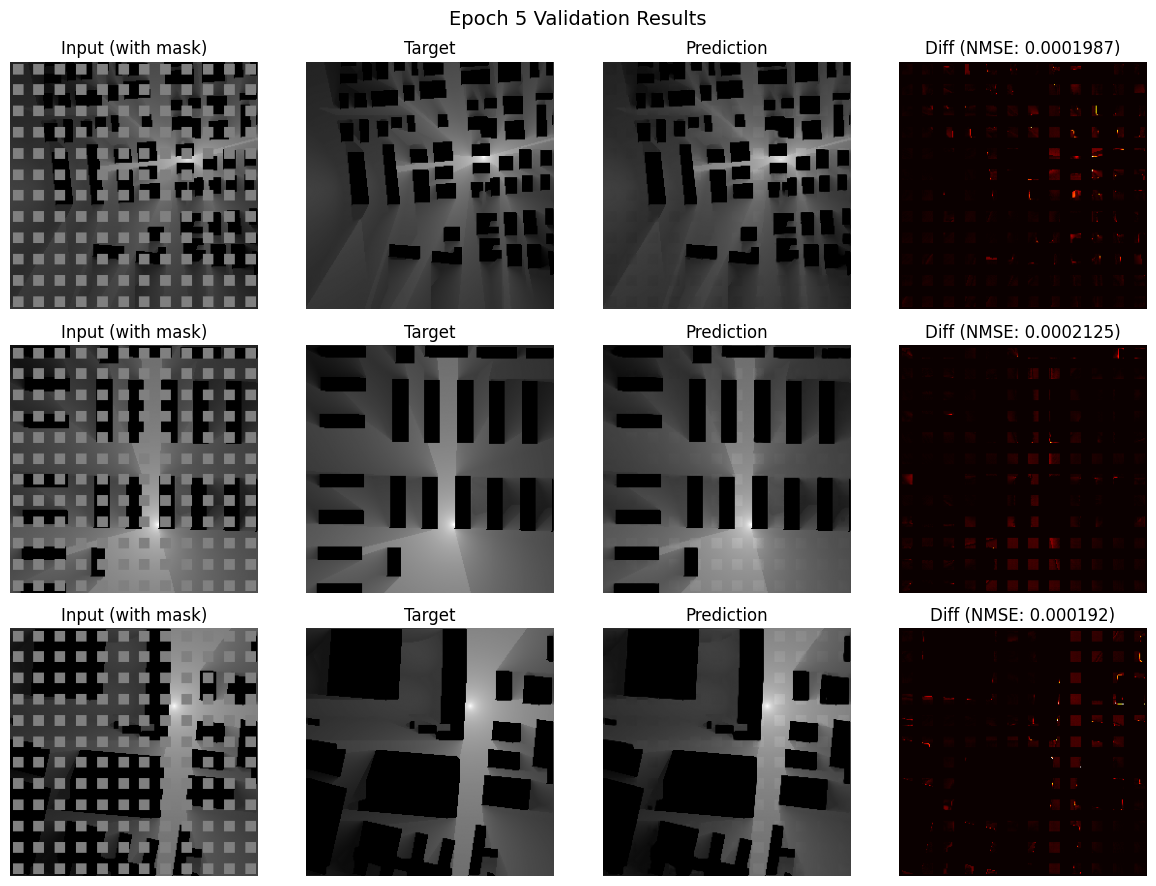

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.53it/s]



Epoch 6/100:
  Train - Loss: 0.000909, NMSE: 0.0002304
  Val   - Loss: 0.0008575, NMSE: 0.0002231
  LR: 6.98e-05
  >> Saved best model (NMSE: 0.0002231)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.51it/s]



Epoch 7/100:
  Train - Loss: 0.0007898, NMSE: 0.0001963
  Val   - Loss: 0.0006348, NMSE: 0.0001379
  LR: 4.20e-05
  >> Saved best model (NMSE: 0.0001379)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.34it/s]



Epoch 8/100:
  Train - Loss: 0.0006922, NMSE: 0.0001688
  Val   - Loss: 0.0006437, NMSE: 0.0001287
  LR: 2.00e-05
  >> Saved best model (NMSE: 0.0001287)


Validation: 100%|██████████| 220/220 [00:14<00:00, 14.71it/s]



Epoch 9/100:
  Train - Loss: 0.0006193, NMSE: 0.0001507
  Val   - Loss: 0.000514, NMSE: 0.000102
  LR: 5.87e-06
  >> Saved best model (NMSE: 0.000102)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.40it/s]



Epoch 10/100:
  Train - Loss: 0.0005786, NMSE: 0.0001412
  Val   - Loss: 0.0004825, NMSE: 9.367e-05
  LR: 2.00e-04
  >> Saved best model (NMSE: 9.367e-05)


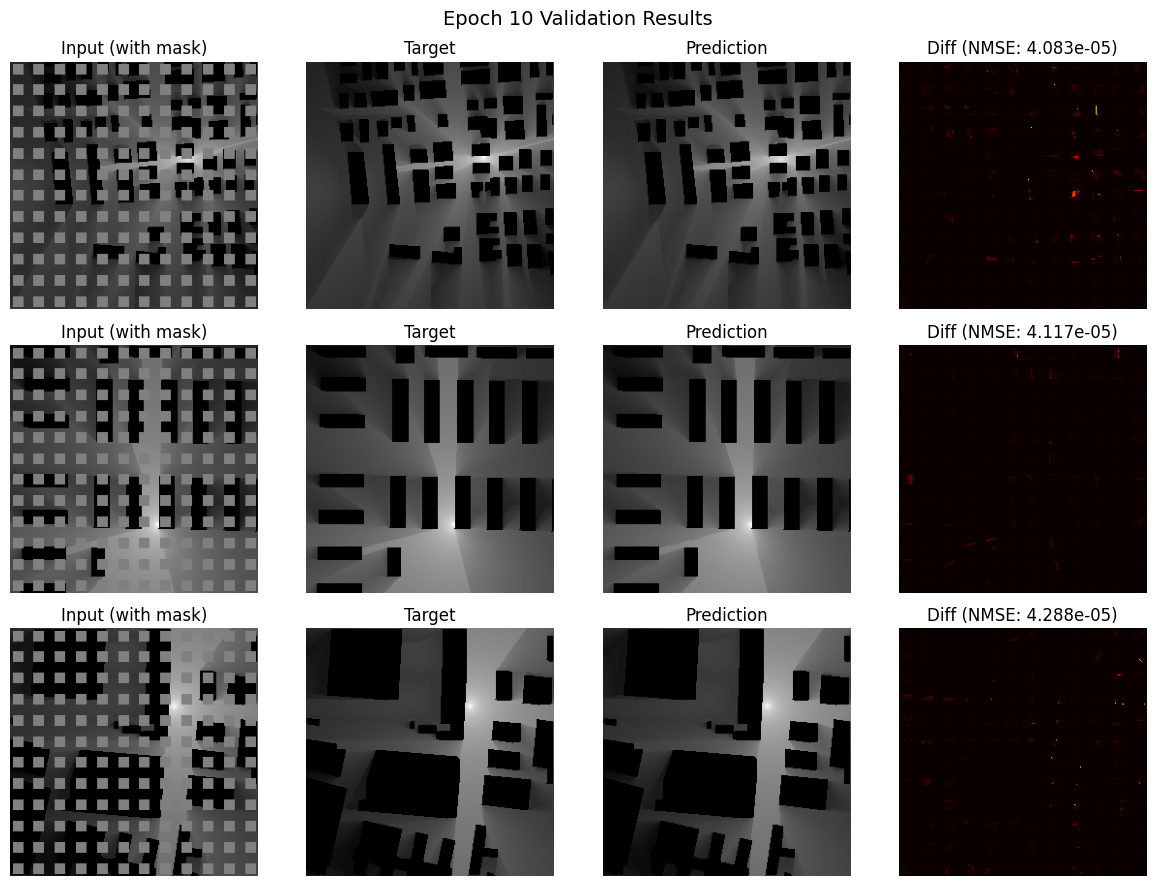

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.56it/s]



Epoch 11/100:
  Train - Loss: 0.002606, NMSE: 0.0009198
  Val   - Loss: 0.002041, NMSE: 0.0005792
  LR: 1.99e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.58it/s]



Epoch 12/100:
  Train - Loss: 0.001527, NMSE: 0.0004453
  Val   - Loss: 0.001228, NMSE: 0.0003499
  LR: 1.95e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.55it/s]



Epoch 13/100:
  Train - Loss: 0.00128, NMSE: 0.0003572
  Val   - Loss: 0.001089, NMSE: 0.0002738
  LR: 1.89e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.47it/s]



Epoch 14/100:
  Train - Loss: 0.001424, NMSE: 0.0004347
  Val   - Loss: 0.001067, NMSE: 0.0003024
  LR: 1.81e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.64it/s]



Epoch 15/100:
  Train - Loss: 0.001085, NMSE: 0.0002925
  Val   - Loss: 0.001051, NMSE: 0.0002462
  LR: 1.71e-04


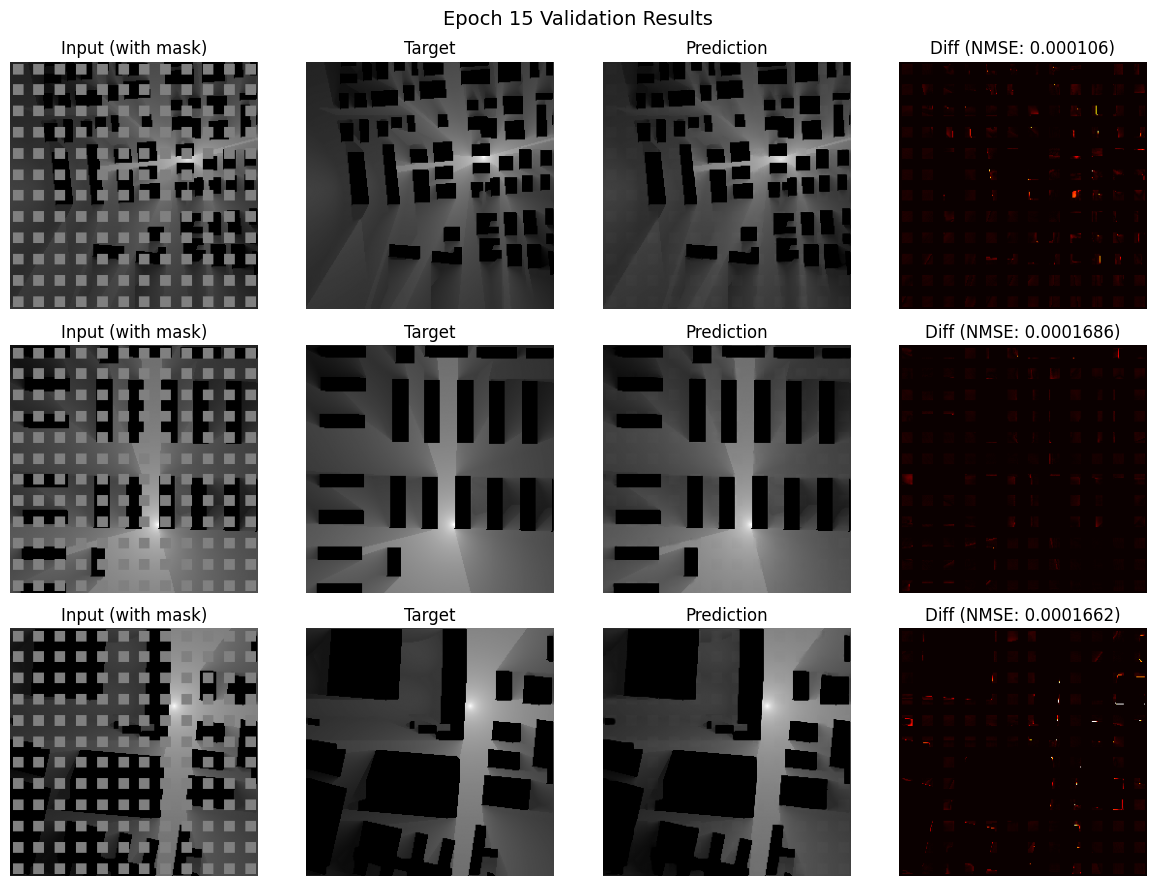

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.38it/s]



Epoch 16/100:
  Train - Loss: 0.0009604, NMSE: 0.000254
  Val   - Loss: 0.001049, NMSE: 0.0002248
  LR: 1.59e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.61it/s]



Epoch 17/100:
  Train - Loss: 0.0008873, NMSE: 0.00023
  Val   - Loss: 0.0008101, NMSE: 0.0002172
  LR: 1.46e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.38it/s]



Epoch 18/100:
  Train - Loss: 0.0008165, NMSE: 0.000208
  Val   - Loss: 0.0006372, NMSE: 0.0001576
  LR: 1.31e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.36it/s]



Epoch 19/100:
  Train - Loss: 0.0007426, NMSE: 0.0001879
  Val   - Loss: 0.000584, NMSE: 0.0001551
  LR: 1.16e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.46it/s]


Epoch 20/100:
  Train - Loss: 0.0006898, NMSE: 0.0001724
  Val   - Loss: 0.0005943, NMSE: 0.0001301
  LR: 1.01e-04


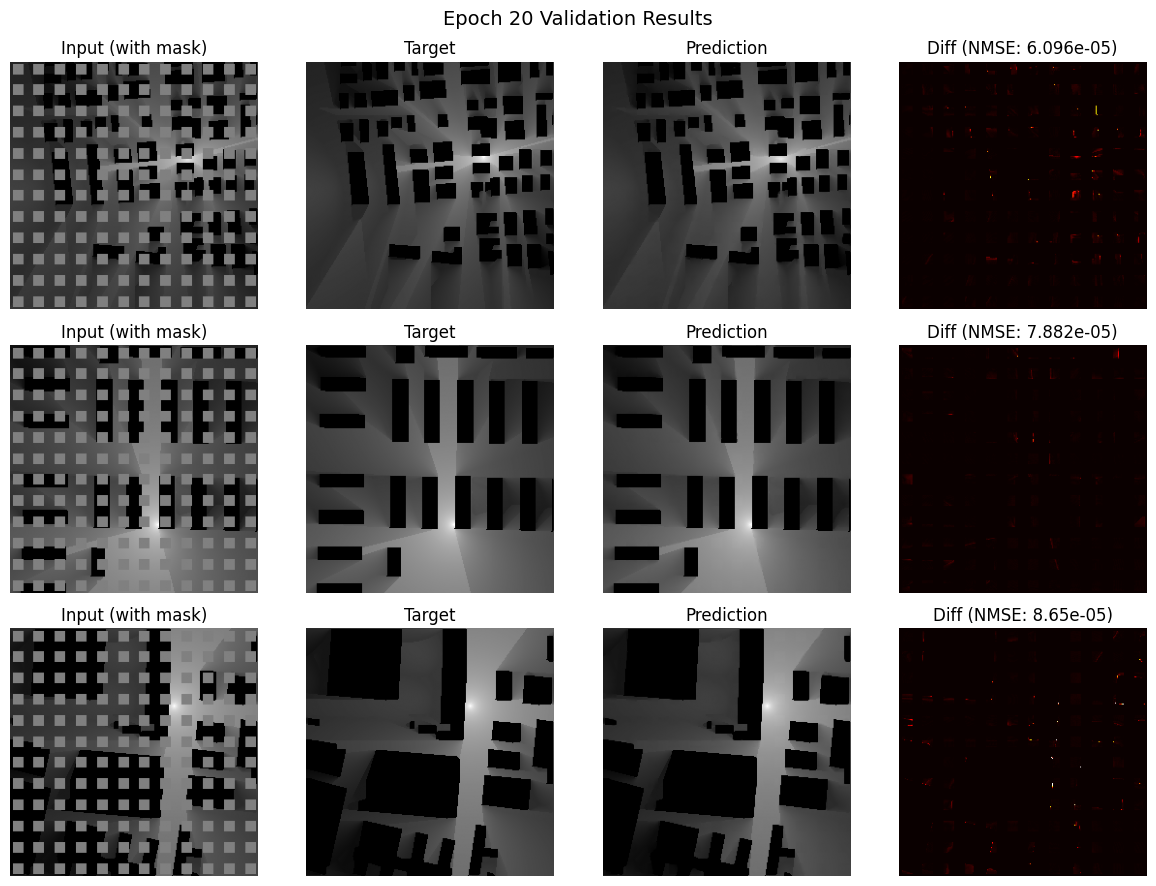

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.30it/s]



Epoch 21/100:
  Train - Loss: 0.0006378, NMSE: 0.000157
  Val   - Loss: 0.0005777, NMSE: 0.0001163
  LR: 8.49e-05


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.57it/s]



Epoch 22/100:
  Train - Loss: 0.0005935, NMSE: 0.0001439
  Val   - Loss: 0.0005151, NMSE: 0.0001063
  LR: 6.98e-05


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.30it/s]



Epoch 23/100:
  Train - Loss: 0.0005526, NMSE: 0.0001322
  Val   - Loss: 0.0005521, NMSE: 9.246e-05
  LR: 5.53e-05
  >> Saved best model (NMSE: 9.246e-05)


Validation: 100%|██████████| 220/220 [00:14<00:00, 14.70it/s]



Epoch 24/100:
  Train - Loss: 0.0005196, NMSE: 0.0001231
  Val   - Loss: 0.0004279, NMSE: 7.675e-05
  LR: 4.20e-05
  >> Saved best model (NMSE: 7.675e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.47it/s]



Epoch 25/100:
  Train - Loss: 0.0004866, NMSE: 0.0001148
  Val   - Loss: 0.0004354, NMSE: 7.315e-05
  LR: 3.01e-05
  >> Saved best model (NMSE: 7.315e-05)


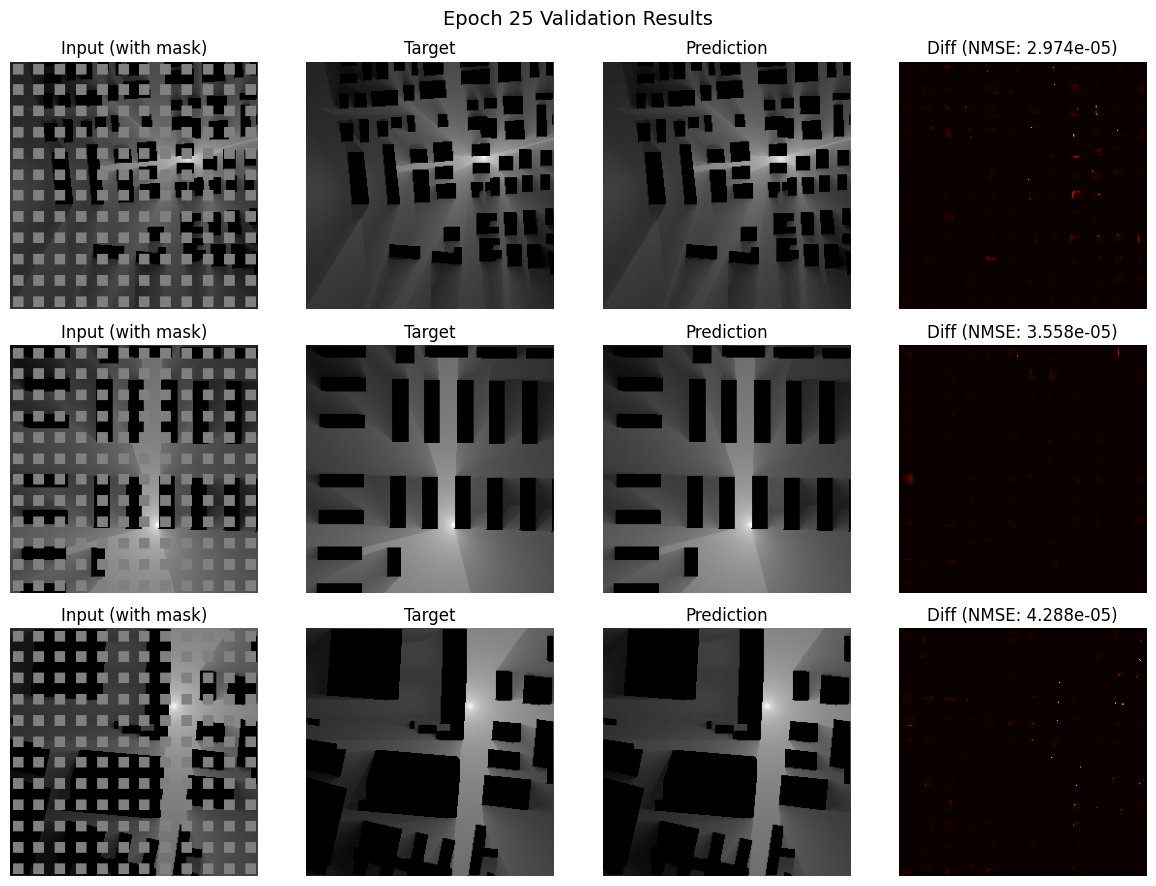

Validation: 100%|██████████| 220/220 [00:14<00:00, 14.67it/s]



Epoch 26/100:
  Train - Loss: 0.0004593, NMSE: 0.0001079
  Val   - Loss: 0.000349, NMSE: 6.316e-05
  LR: 2.00e-05
  >> Saved best model (NMSE: 6.316e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.64it/s]



Epoch 27/100:
  Train - Loss: 0.000441, NMSE: 0.0001034
  Val   - Loss: 0.0003343, NMSE: 5.889e-05
  LR: 1.18e-05
  >> Saved best model (NMSE: 5.889e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.30it/s]



Epoch 28/100:
  Train - Loss: 0.0004238, NMSE: 0.0001
  Val   - Loss: 0.0003296, NMSE: 5.722e-05
  LR: 5.87e-06
  >> Saved best model (NMSE: 5.722e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.42it/s]



Epoch 29/100:
  Train - Loss: 0.0004136, NMSE: 9.762e-05
  Val   - Loss: 0.0003227, NMSE: 5.528e-05
  LR: 2.23e-06
  >> Saved best model (NMSE: 5.528e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.61it/s]



Epoch 30/100:
  Train - Loss: 0.0004084, NMSE: 9.624e-05
  Val   - Loss: 0.000321, NMSE: 5.453e-05
  LR: 2.00e-04
  >> Saved best model (NMSE: 5.453e-05)


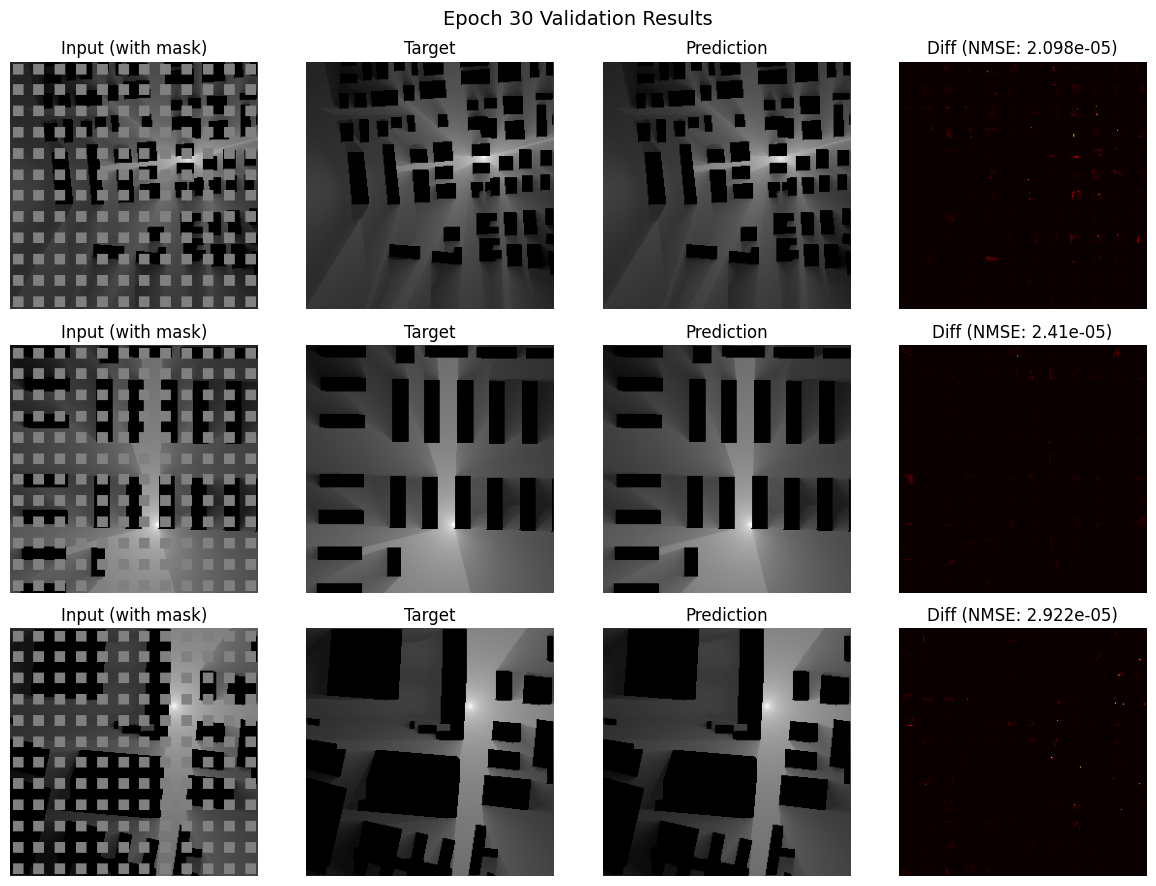

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.59it/s]



Epoch 31/100:
  Train - Loss: 0.001272, NMSE: 0.0003786
  Val   - Loss: 0.0009138, NMSE: 0.0001714
  LR: 2.00e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.48it/s]



Epoch 32/100:
  Train - Loss: 0.000688, NMSE: 0.0001627
  Val   - Loss: 0.0006072, NMSE: 0.0001547
  LR: 1.99e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.45it/s]



Epoch 33/100:
  Train - Loss: 0.0006582, NMSE: 0.0001528
  Val   - Loss: 0.0006721, NMSE: 0.0001511
  LR: 1.97e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.61it/s]



Epoch 34/100:
  Train - Loss: 0.000617, NMSE: 0.000143
  Val   - Loss: 0.0004723, NMSE: 8.681e-05
  LR: 1.95e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.60it/s]



Epoch 35/100:
  Train - Loss: 0.0006086, NMSE: 0.0001367
  Val   - Loss: 0.0008581, NMSE: 0.0001492
  LR: 1.92e-04


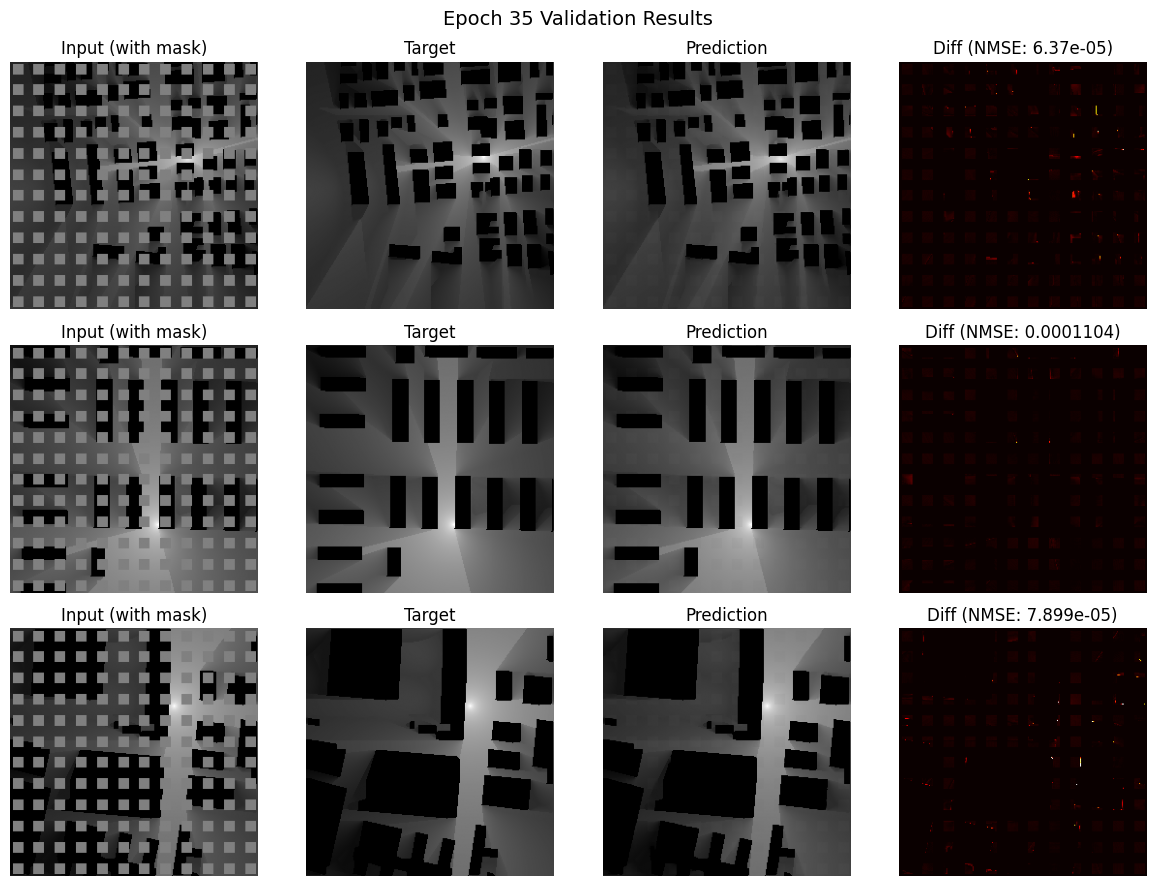

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.62it/s]



Epoch 36/100:
  Train - Loss: 0.000577, NMSE: 0.0001279
  Val   - Loss: 0.000528, NMSE: 9.074e-05
  LR: 1.89e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.49it/s]



Epoch 37/100:
  Train - Loss: 0.0005589, NMSE: 0.000122
  Val   - Loss: 0.000508, NMSE: 9.565e-05
  LR: 1.85e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.62it/s]



Epoch 38/100:
  Train - Loss: 0.0005348, NMSE: 0.0001147
  Val   - Loss: 0.0006579, NMSE: 9.676e-05
  LR: 1.81e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.38it/s]



Epoch 39/100:
  Train - Loss: 0.0005236, NMSE: 0.0001111
  Val   - Loss: 0.0004616, NMSE: 6.872e-05
  LR: 1.76e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.34it/s]



Epoch 40/100:
  Train - Loss: 0.0004959, NMSE: 0.0001031
  Val   - Loss: 0.0004102, NMSE: 8.437e-05
  LR: 1.71e-04


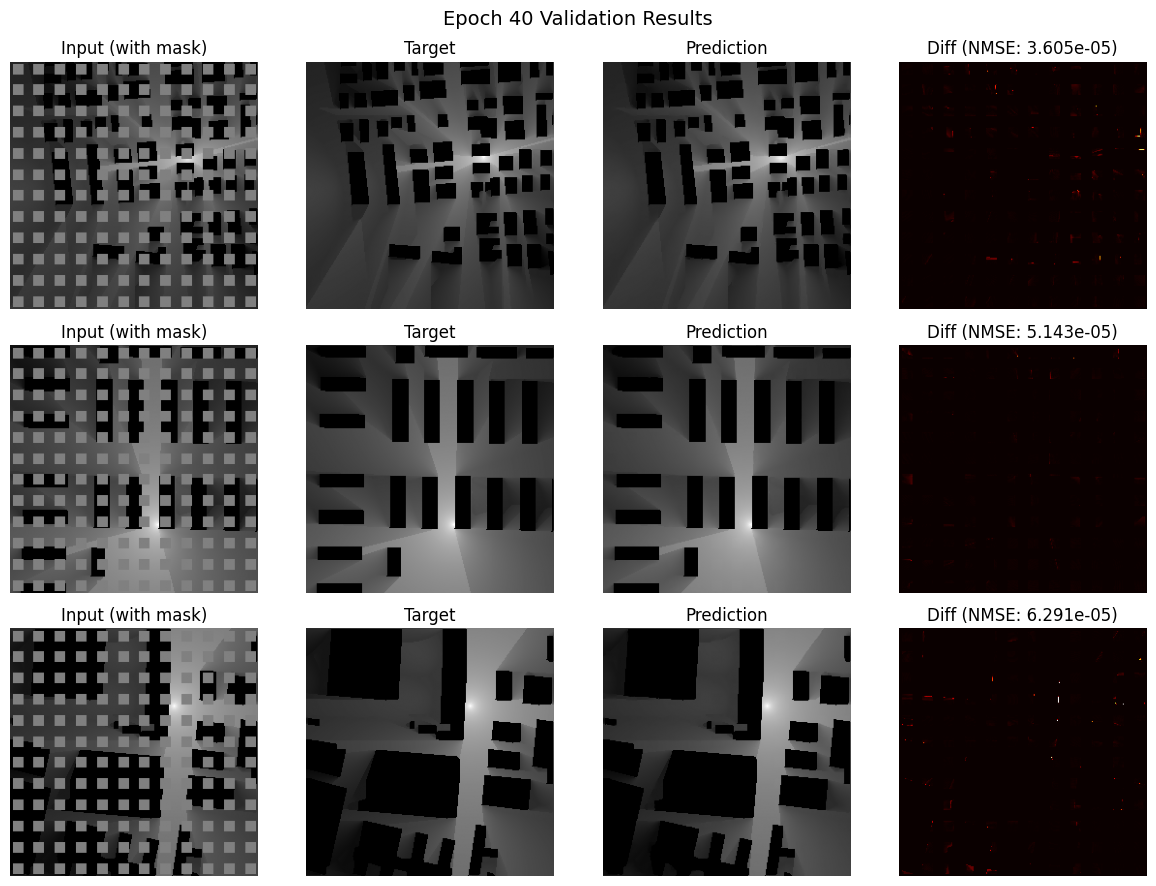

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.51it/s]



Epoch 41/100:
  Train - Loss: 0.0004801, NMSE: 9.875e-05
  Val   - Loss: 0.000515, NMSE: 6.575e-05
  LR: 1.65e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.58it/s]



Epoch 42/100:
  Train - Loss: 0.0004623, NMSE: 9.342e-05
  Val   - Loss: 0.0006697, NMSE: 7.865e-05
  LR: 1.59e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.34it/s]



Epoch 43/100:
  Train - Loss: 0.0004464, NMSE: 8.834e-05
  Val   - Loss: 0.0004487, NMSE: 5.154e-05
  LR: 1.52e-04
  >> Saved best model (NMSE: 5.154e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.34it/s]



Epoch 44/100:
  Train - Loss: 0.0004275, NMSE: 8.413e-05
  Val   - Loss: 0.0003994, NMSE: 6.261e-05
  LR: 1.46e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.36it/s]



Epoch 45/100:
  Train - Loss: 0.0004171, NMSE: 8e-05
  Val   - Loss: 0.0003392, NMSE: 4.935e-05
  LR: 1.39e-04
  >> Saved best model (NMSE: 4.935e-05)


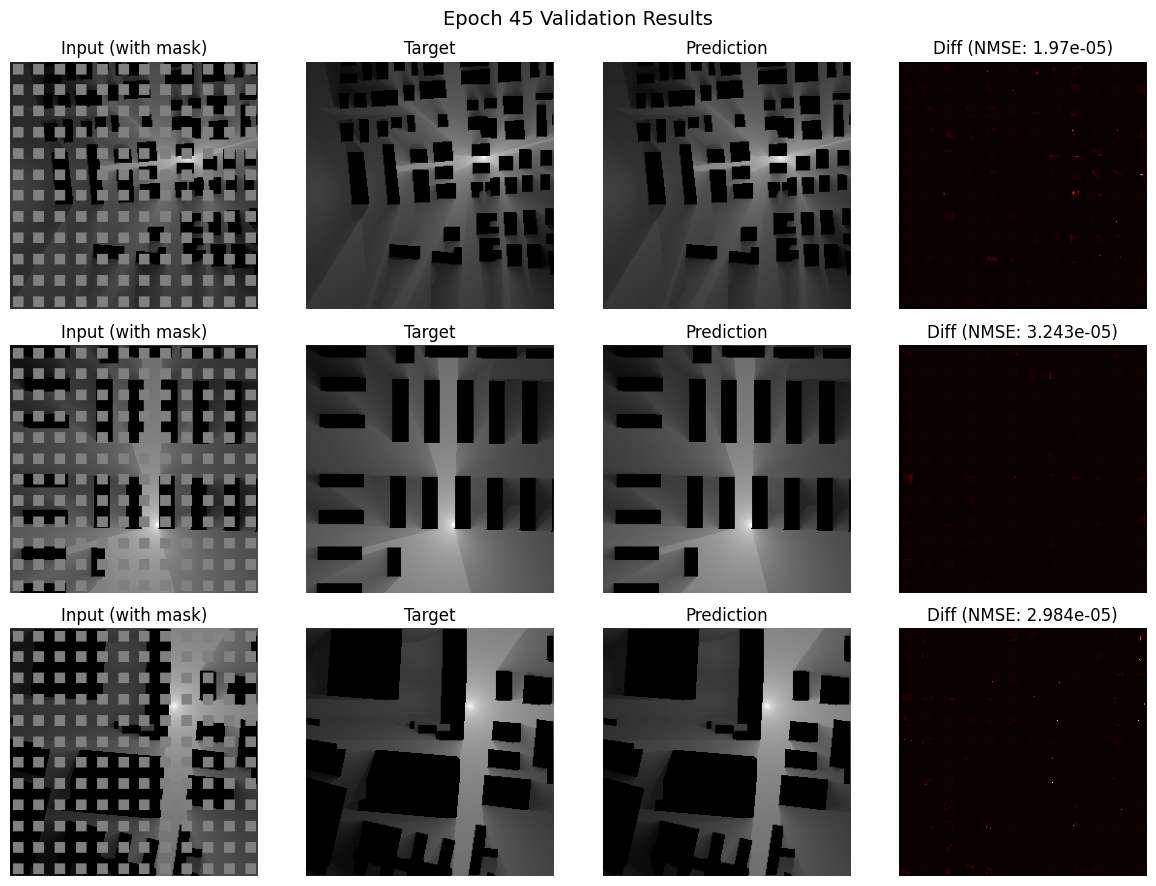

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.57it/s]



Epoch 46/100:
  Train - Loss: 0.0004025, NMSE: 7.601e-05
  Val   - Loss: 0.0003136, NMSE: 4.278e-05
  LR: 1.31e-04
  >> Saved best model (NMSE: 4.278e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.55it/s]



Epoch 47/100:
  Train - Loss: 0.0003868, NMSE: 7.243e-05
  Val   - Loss: 0.0003821, NMSE: 4.509e-05
  LR: 1.24e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.42it/s]



Epoch 48/100:
  Train - Loss: 0.0003732, NMSE: 6.908e-05
  Val   - Loss: 0.0003106, NMSE: 4.31e-05
  LR: 1.16e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.37it/s]



Epoch 49/100:
  Train - Loss: 0.0003608, NMSE: 6.531e-05
  Val   - Loss: 0.0002738, NMSE: 3.721e-05
  LR: 1.08e-04
  >> Saved best model (NMSE: 3.721e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.42it/s]



Epoch 50/100:
  Train - Loss: 0.0003491, NMSE: 6.229e-05
  Val   - Loss: 0.0002791, NMSE: 3.397e-05
  LR: 1.01e-04
  >> Saved best model (NMSE: 3.397e-05)


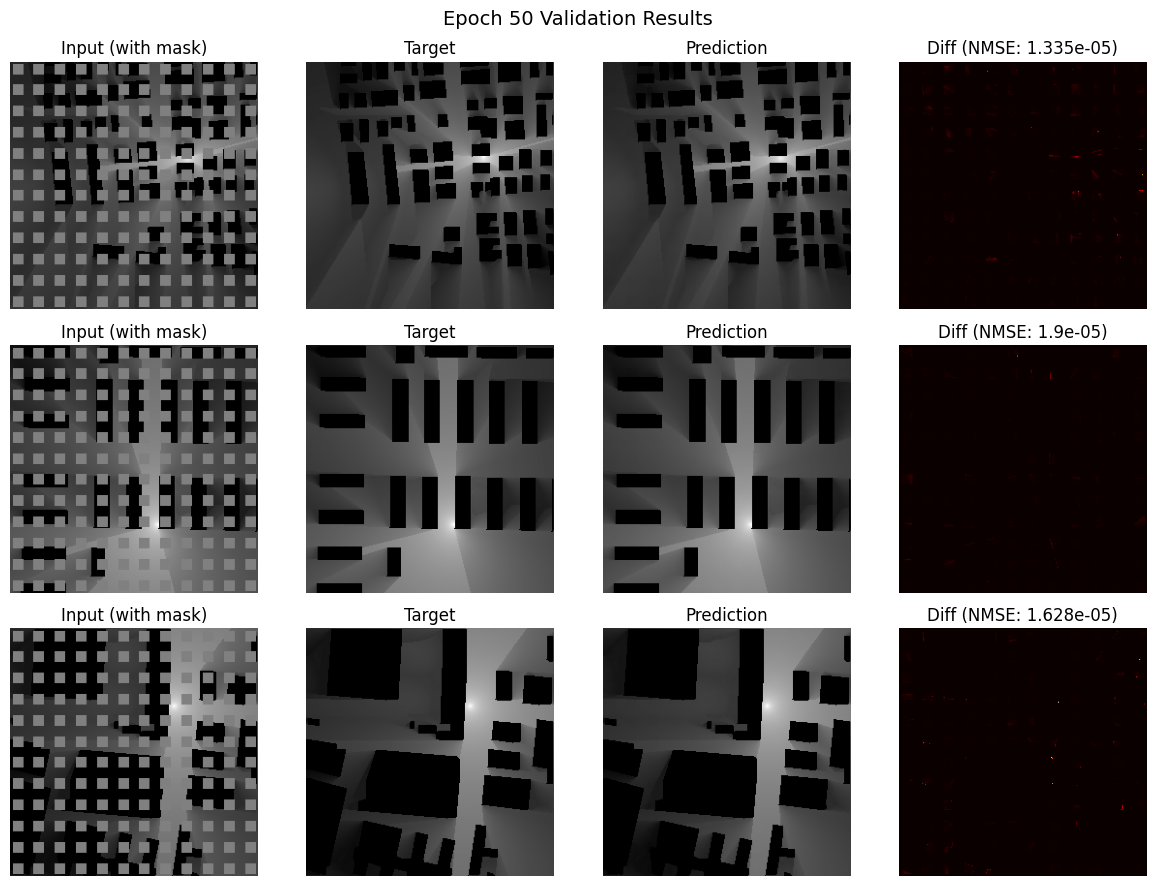

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.50it/s]



Epoch 51/100:
  Train - Loss: 0.0003379, NMSE: 5.998e-05
  Val   - Loss: 0.0003266, NMSE: 3.283e-05
  LR: 9.27e-05
  >> Saved best model (NMSE: 3.283e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.47it/s]



Epoch 52/100:
  Train - Loss: 0.000325, NMSE: 5.688e-05
  Val   - Loss: 0.0004087, NMSE: 3.377e-05
  LR: 8.49e-05


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.26it/s]



Epoch 53/100:
  Train - Loss: 0.0003161, NMSE: 5.451e-05
  Val   - Loss: 0.0002423, NMSE: 2.885e-05
  LR: 7.73e-05
  >> Saved best model (NMSE: 2.885e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.32it/s]



Epoch 54/100:
  Train - Loss: 0.0003055, NMSE: 5.231e-05
  Val   - Loss: 0.0002708, NMSE: 3.019e-05
  LR: 6.98e-05


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.30it/s]



Epoch 55/100:
  Train - Loss: 0.0002953, NMSE: 4.97e-05
  Val   - Loss: 0.0003023, NMSE: 2.597e-05
  LR: 6.24e-05
  >> Saved best model (NMSE: 2.597e-05)


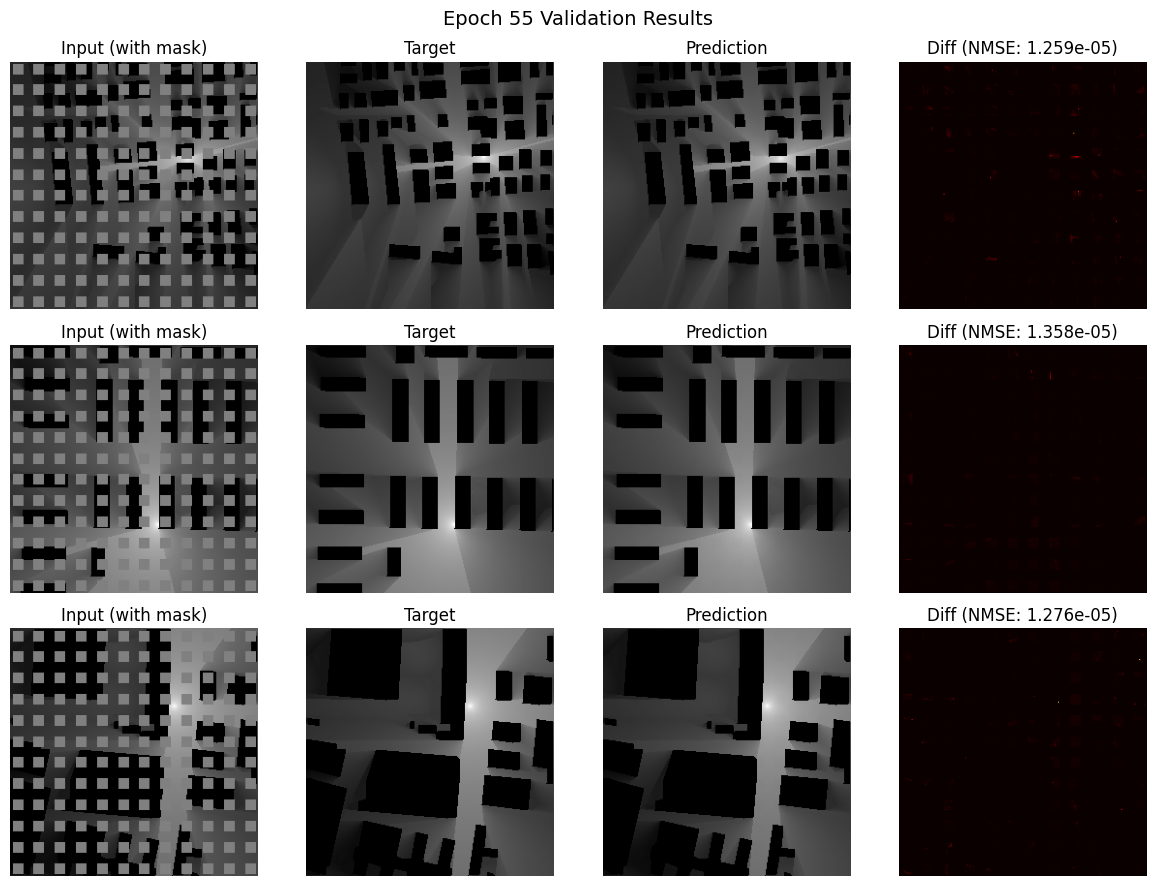

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.41it/s]



Epoch 56/100:
  Train - Loss: 0.0002874, NMSE: 4.776e-05
  Val   - Loss: 0.0002653, NMSE: 2.44e-05
  LR: 5.53e-05
  >> Saved best model (NMSE: 2.44e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.26it/s]



Epoch 57/100:
  Train - Loss: 0.0002776, NMSE: 4.622e-05
  Val   - Loss: 0.0002632, NMSE: 2.294e-05
  LR: 4.85e-05
  >> Saved best model (NMSE: 2.294e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.43it/s]



Epoch 58/100:
  Train - Loss: 0.0002721, NMSE: 4.466e-05
  Val   - Loss: 0.0002181, NMSE: 2.116e-05
  LR: 4.20e-05
  >> Saved best model (NMSE: 2.116e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.41it/s]



Epoch 59/100:
  Train - Loss: 0.0002641, NMSE: 4.302e-05
  Val   - Loss: 0.0002125, NMSE: 2.138e-05
  LR: 3.59e-05


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.51it/s]



Epoch 60/100:
  Train - Loss: 0.0002566, NMSE: 4.143e-05
  Val   - Loss: 0.0002063, NMSE: 1.976e-05
  LR: 3.01e-05
  >> Saved best model (NMSE: 1.976e-05)


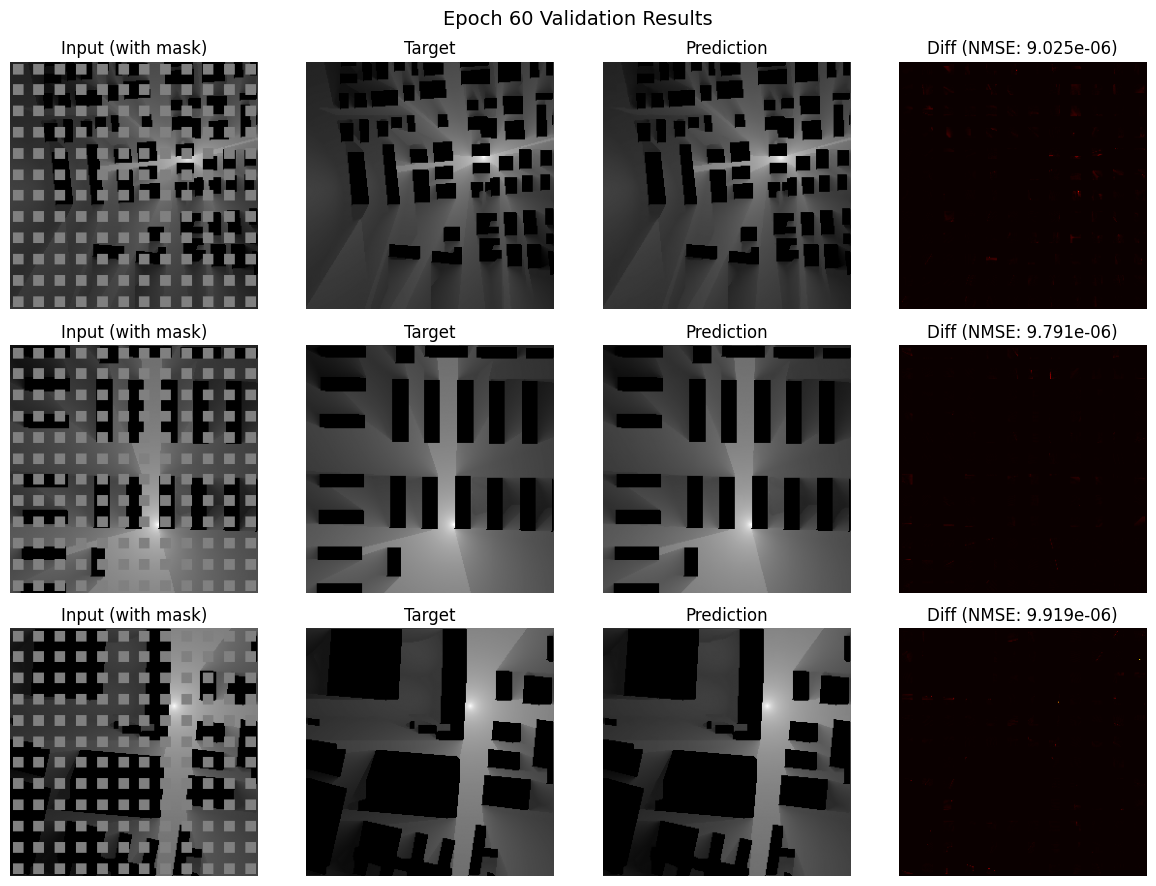

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.34it/s]



Epoch 61/100:
  Train - Loss: 0.0002512, NMSE: 4.037e-05
  Val   - Loss: 0.0002026, NMSE: 1.905e-05
  LR: 2.48e-05
  >> Saved best model (NMSE: 1.905e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.35it/s]



Epoch 62/100:
  Train - Loss: 0.0002462, NMSE: 3.908e-05
  Val   - Loss: 0.0002117, NMSE: 1.881e-05
  LR: 2.00e-05
  >> Saved best model (NMSE: 1.881e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.35it/s]



Epoch 63/100:
  Train - Loss: 0.0002429, NMSE: 3.838e-05
  Val   - Loss: 0.0001929, NMSE: 1.827e-05
  LR: 1.57e-05
  >> Saved best model (NMSE: 1.827e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.51it/s]



Epoch 64/100:
  Train - Loss: 0.0002382, NMSE: 3.757e-05
  Val   - Loss: 0.0001933, NMSE: 1.791e-05
  LR: 1.18e-05
  >> Saved best model (NMSE: 1.791e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.27it/s]



Epoch 65/100:
  Train - Loss: 0.0002351, NMSE: 3.682e-05
  Val   - Loss: 0.0002009, NMSE: 1.781e-05
  LR: 8.57e-06
  >> Saved best model (NMSE: 1.781e-05)


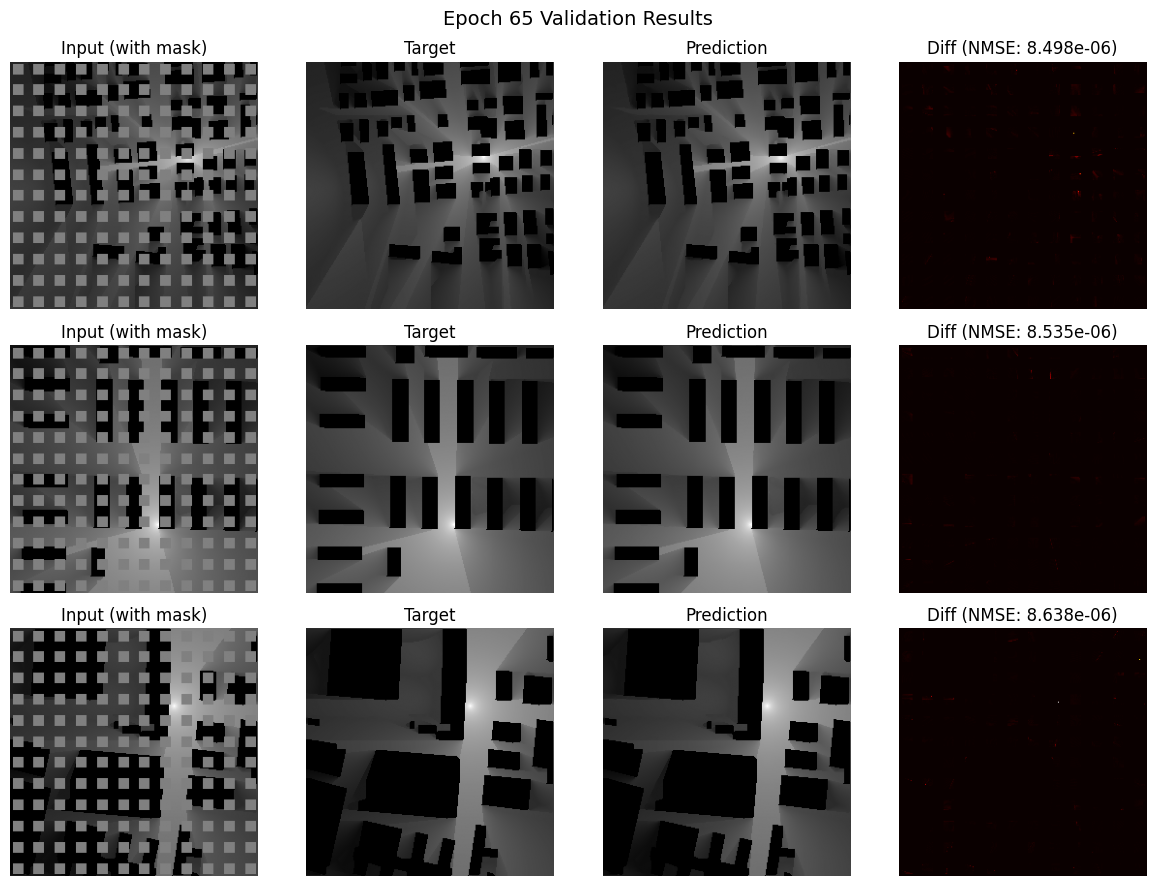

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.31it/s]



Epoch 66/100:
  Train - Loss: 0.0002323, NMSE: 3.628e-05
  Val   - Loss: 0.0001899, NMSE: 1.754e-05
  LR: 5.87e-06
  >> Saved best model (NMSE: 1.754e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.41it/s]



Epoch 67/100:
  Train - Loss: 0.0002306, NMSE: 3.594e-05
  Val   - Loss: 0.0001876, NMSE: 1.728e-05
  LR: 3.75e-06
  >> Saved best model (NMSE: 1.728e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.31it/s]



Epoch 68/100:
  Train - Loss: 0.0002292, NMSE: 3.567e-05
  Val   - Loss: 0.000187, NMSE: 1.718e-05
  LR: 2.23e-06
  >> Saved best model (NMSE: 1.718e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.29it/s]



Epoch 69/100:
  Train - Loss: 0.000228, NMSE: 3.542e-05
  Val   - Loss: 0.0001881, NMSE: 1.715e-05
  LR: 1.31e-06
  >> Saved best model (NMSE: 1.715e-05)


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.59it/s]



Epoch 70/100:
  Train - Loss: 0.0002274, NMSE: 3.533e-05
  Val   - Loss: 0.0001898, NMSE: 1.712e-05
  LR: 2.00e-04
  >> Saved best model (NMSE: 1.712e-05)


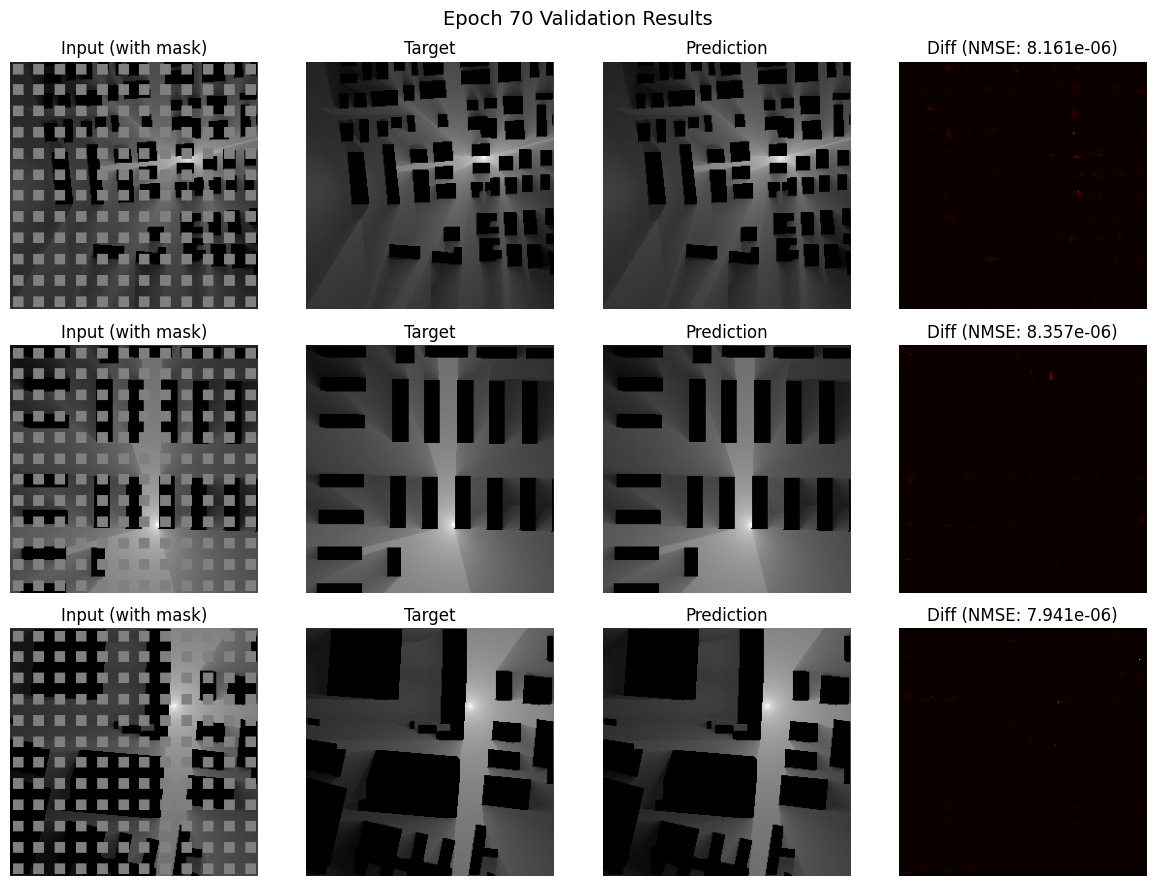

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.42it/s]



Epoch 71/100:
  Train - Loss: 0.0009658, NMSE: 0.0002935
  Val   - Loss: 0.0007813, NMSE: 8.689e-05
  LR: 2.00e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.55it/s]



Epoch 72/100:
  Train - Loss: 0.000403, NMSE: 7.544e-05
  Val   - Loss: 0.0003885, NMSE: 6.828e-05
  LR: 2.00e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.29it/s]



Epoch 73/100:
  Train - Loss: 0.0003938, NMSE: 7.261e-05
  Val   - Loss: 0.0002974, NMSE: 4.928e-05
  LR: 1.99e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.14it/s]



Epoch 74/100:
  Train - Loss: 0.0003885, NMSE: 7.144e-05
  Val   - Loss: 0.0003719, NMSE: 8.758e-05
  LR: 1.99e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.14it/s]


Epoch 75/100:
  Train - Loss: 0.0003842, NMSE: 6.985e-05
  Val   - Loss: 0.000368, NMSE: 3.881e-05
  LR: 1.98e-04


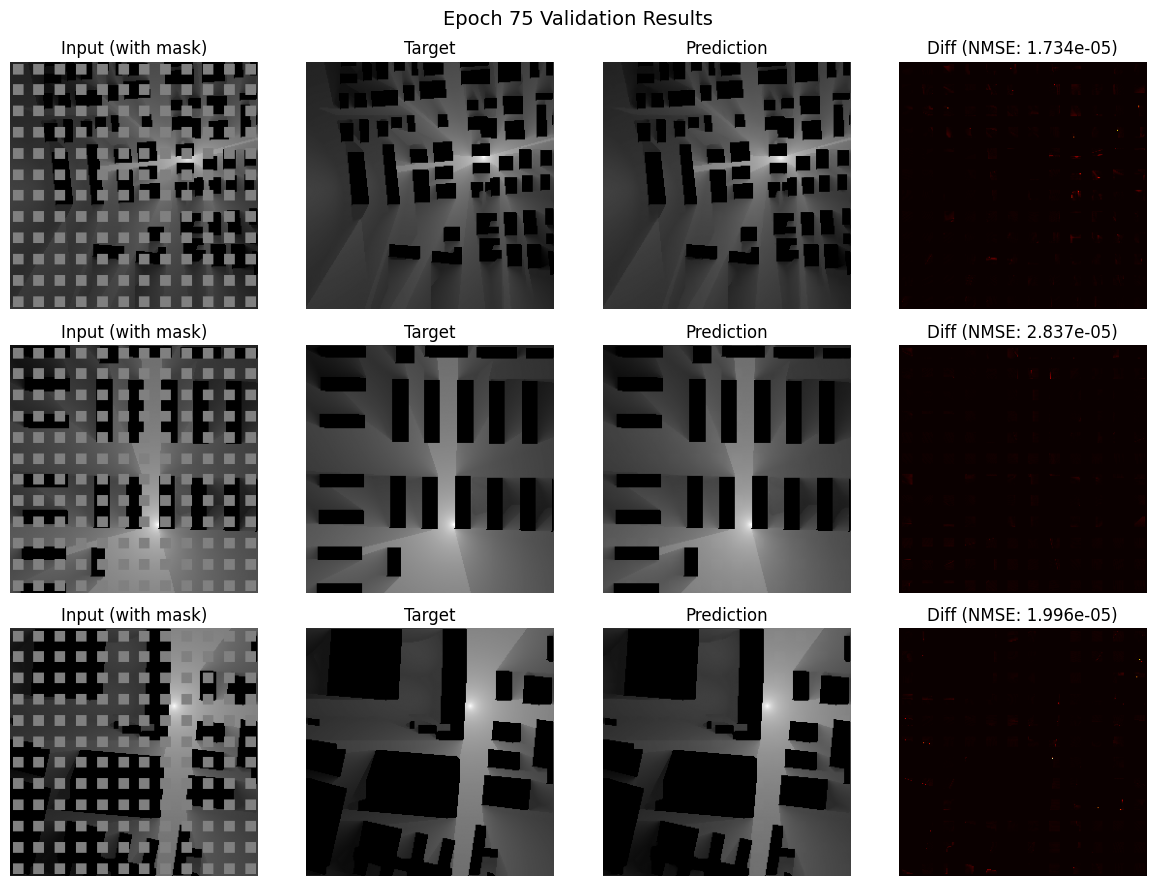

Validation: 100%|██████████| 220/220 [00:15<00:00, 14.25it/s]



Epoch 76/100:
  Train - Loss: 0.0003782, NMSE: 6.796e-05
  Val   - Loss: 0.0004482, NMSE: 4.277e-05
  LR: 1.97e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.23it/s]



Epoch 77/100:
  Train - Loss: 0.0003726, NMSE: 6.625e-05
  Val   - Loss: 0.0003204, NMSE: 3.758e-05
  LR: 1.96e-04


Validation: 100%|██████████| 220/220 [00:15<00:00, 14.39it/s]



Epoch 78/100:
  Train - Loss: 0.0003672, NMSE: 6.438e-05
  Val   - Loss: 0.0004887, NMSE: 5.358e-05
  LR: 1.95e-04


Epoch 79/100:  18%|█▊        | 236/1315 [00:48<03:40,  4.90it/s, Loss=0.0003422, NMSE=4.803e-05, Perceptual=9.764e-05]

In [ ]:
# Initialize model
model = SceneAwareGenerator(
    input_nc=2,
    output_nc=1,
    ngf=config.ngf,
    n_maps=701,
    n_bs=80,
    embed_dim=config.embed_dim,
    n_blocks=config.n_blocks,
    use_dropout=config.use_dropout
)
model = model.to(device)

# Loss function
criterion = SceneAwareLoss(
    mse_weight=config.mse_weight,
    perceptual_weight=config.perceptual_weight,
    tv_weight=config.tv_weight
)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    betas=(config.beta1, config.beta2),
    weight_decay=config.weight_decay
)

# Learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

# Training history
history = {
    'train_loss': [],
    'train_nmse': [],
    'val_loss': [],
    'val_nmse': []
}

best_val_nmse = float('inf')
best_epoch = 0

# Training loop
print("Starting Scene-Aware RME-GAN training...")
print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(val_dataset)} samples")

for epoch in range(1, config.epochs + 1):
    # Train
    train_loss, train_nmse = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch, config
    )
    
    # Validate
    val_loss, val_nmse = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_nmse'].append(train_nmse)
    history['val_loss'].append(val_loss)
    history['val_nmse'].append(val_nmse)
    
    # Print progress
    print(f"\nEpoch {epoch}/{config.epochs}:")
    print(f"  Train - Loss: {train_loss:.4g}, NMSE: {train_nmse:.4g}")
    print(f"  Val   - Loss: {val_loss:.4g}, NMSE: {val_nmse:.4g}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if val_nmse < best_val_nmse:
        best_val_nmse = val_nmse
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_nmse': val_nmse,
            # Save config parameters instead of config object to avoid pickle issues
            'config_dict': {
                'batch_size': config.batch_size,
                'ngf': config.ngf,
                'n_blocks': config.n_blocks,
                'embed_dim': config.embed_dim,
                'learning_rate': config.learning_rate,
                'epochs': config.epochs
            }
        }, os.path.join(MODEL_PATH, 'best_model.pth'))
        print(f"  >> Saved best model (NMSE: {val_nmse:.4g})")
    
    # Visualize results
    if epoch % config.visualize_interval == 0:
        visualize_results(model, val_loader, device, epoch, num_samples=3)
    
    # Save checkpoint
    if epoch % config.save_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, os.path.join(MODEL_PATH, f'checkpoint_epoch_{epoch}.pth'))

print(f"\nTraining complete!")
print(f"Best model: Epoch {best_epoch}, Val NMSE: {best_val_nmse:.4g}")

## 9. Training Curves

In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
ax1.plot(history['train_loss'], label='Train Loss', alpha=0.7)
ax1.plot(history['val_loss'], label='Val Loss', marker='o', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# NMSE curves
ax2.plot(history['train_nmse'], label='Train NMSE', alpha=0.7)
ax2.plot(history['val_nmse'], label='Val NMSE', marker='o', markersize=3)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('NMSE')
ax2.set_title('Training and Validation NMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Mark best epoch
ax2.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best: {best_val_nmse:.4g}')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'training_curves.png'), dpi=300)
plt.show()

print(f"Final training NMSE: {history['train_nmse'][-1]:.4g}")
print(f"Final validation NMSE: {history['val_nmse'][-1]:.4g}")
print(f"Best validation NMSE: {best_val_nmse:.4g} (Epoch {best_epoch})")

## 10. Test Set Prediction

In [ ]:
# Load best model
checkpoint = torch.load(os.path.join(MODEL_PATH, 'best_model.pth'), weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} (Val NMSE: {checkpoint['val_nmse']:.4g})")

# Predict on test set
model.eval()
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        # Prepare data
        input_img = batch['input'].to(device)
        target_img = batch['target'].to(device)  # Original image
        mask = batch['mask'].to(device)
        map_id = batch['map_id'].to(device)
        bs_id = batch['bs_id'].to(device)
        filename = batch['filename'][0]
        
        # Model input
        model_input = torch.cat([input_img, mask], dim=1)
        
        # Forward pass
        output = model(model_input, map_id, bs_id)
        
        # Fuse with original (key: use target_img not input_img for unmasked regions)
        final_output = target_img * mask + output * (1 - mask)
        
        # Save prediction
        output_np = (final_output[0, 0].cpu().numpy() * 255).astype(np.uint8)
        output_img = Image.fromarray(output_np, mode='L')
        
        # Save image
        output_path = os.path.join(OUTPUT_PATH, f'pred_{filename}')
        output_img.save(output_path)
        
        predictions.append({
            'filename': filename,
            'map_id': map_id.item(),
            'bs_id': bs_id.item(),
            'output_path': output_path
        })

# Statistics
print(f"\nTest complete!")
print(f"Predictions saved to: {OUTPUT_PATH}")
print(f"Total predictions: {len(predictions)}")

## 11. Final Results Analysis

In [ ]:
# Analyze results by map and BS position
import pandas as pd

# Convert predictions to DataFrame
df = pd.DataFrame(predictions)

# Statistics by BS position
bs_counts = df['bs_id'].value_counts().sort_index()
print("Predictions by Base Station Position:")
print(bs_counts.to_string())

# Statistics by map
print(f"\nTotal unique maps: {df['map_id'].nunique()}")
print(f"Total predictions: {len(predictions)}")

# Summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Model: Scene-Aware RME-GAN")
print(f"Training epochs: {config.epochs}")
print(f"Best validation NMSE: {best_val_nmse:.4g} (Epoch {best_epoch})")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Output directory: {OUTPUT_PATH}")